# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.12.0


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Train model

In [6]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9340 - val_loss: 0.1029 - val_sparse_categorical_accuracy: 0.9696
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.0792 - val_sparse_categorical_accuracy: 0.9755
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0703 - val_sparse_categorical_accuracy: 0.9789
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0628 - val_sparse_categorical_accuracy: 0.9802
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0712 - val_sparse_categorical_accuracy: 0.9788


In [7]:
test_img = test_images[:1]
prediction = model.predict(test_img)
prediction

1/1 [==============================] - 0s 55ms/step


array([[ -4.905877  ,  -9.187447  ,  -2.8795028 ,   1.3767843 ,
        -15.4029665 ,  -7.6810102 , -19.185678  ,  11.043241  ,
         -4.4098043 ,   0.70357376]], dtype=float32)

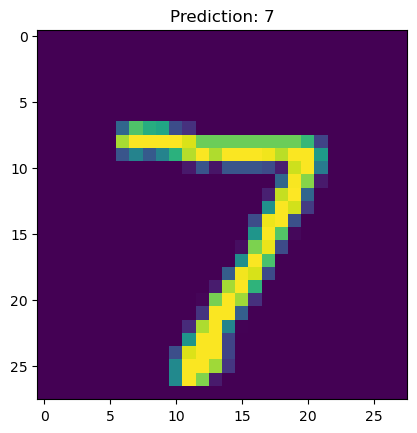

In [8]:
plt.figure()
plt.title("Prediction: {}".format(np.argmax(prediction)))
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [9]:
subprocess.call("rm -rf mnist_model".split())

0

In [10]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


INFO:tensorflow:Assets written to: mnist_model/assets


### Inspect saved model

In [11]:
subprocess.call("tree mnist_model".split())

mnist_model
├── assets
├── fingerprint.pb
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 5 files


0

In [12]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: serving_default_dense_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


0

### Load model

In [13]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [14]:
new_model.inputs

[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>]

### Predict

In [15]:
new_model.predict(test_images[:1])

1/1 [==============================] - 0s 30ms/step


array([[ -4.905877  ,  -9.187447  ,  -2.8795028 ,   1.3767843 ,
        -15.4029665 ,  -7.6810102 , -19.185678  ,  11.043241  ,
         -4.4098043 ,   0.70357376]], dtype=float32)

## PySpark

In [16]:
import pandas as pd

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [17]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(10000, 784)

In [18]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf)

CPU times: user 267 ms, sys: 72.8 ms, total: 340 ms
Wall time: 2.66 s


In [19]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 180 ms, sys: 71.4 ms, total: 251 ms
Wall time: 248 ms


(10000, 1)

In [20]:
%%time
df = spark.createDataFrame(pdf).repartition(10)

CPU times: user 315 ms, sys: 142 ms, total: 458 ms
Wall time: 574 ms


### Save the test dataset as parquet files

In [21]:
df.write.mode("overwrite").parquet("mnist_test")

23/05/09 09:28:17 WARN TaskSetManager: Stage 0 contains a task of very large size (61296 KiB). The maximum recommended task size is 1000 KiB.


### Check arrow memory configuration

In [22]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

23/05/09 09:28:21 WARN TaskSetManager: Stage 3 contains a task of very large size (61296 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark DL API

### 1 column of 784 float

In [23]:
import numpy as np
import pandas as pd

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [24]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model('/home/leey/devpub/leewyang/sparkext/examples/tensorflow/mnist_model')
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [25]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [26]:
df = spark.read.parquet("mnist_test")
len(df.columns)

1

In [27]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [28]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 720 ms, sys: 152 ms, total: 871 ms
Wall time: 9.57 s


In [29]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 529 ms, sys: 109 ms, total: 638 ms
Wall time: 5.87 s


In [30]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 491 ms, sys: 115 ms, total: 606 ms
Wall time: 5.77 s


#### Check predictions

In [31]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.344855, -6.362634, 0.37234622, -7.240332, 0..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.522739, -6.128103, -5.2711368, -0.666756, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.880795, -12.690487, -0.3388724, -4.018896, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24.26865, -20.678307, 0.27521503, -13.965068,..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-13.073485, -7.370237, 8.611007, -0.59536016,..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.197711, -13.125066, -7.8614955, -14.490968..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.0654163, -14.22091, -2.112443, -3.0834715,..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.5243018, -10.069972, -6.676774, 0.03119064..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-16.079163, -5.93364, -4.2674775, 15.075149, ..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.36906046, -16.99096, -3.035135, -13.196101,..."


In [32]:
sample = preds.iloc[0]
sample.preds

array([ 2.344855  , -6.362634  ,  0.37234622, -7.240332  ,  0.9274023 ,
       -4.8879385 , -2.9971154 , -4.8150945 , -6.0440454 , -1.9948431 ],
      dtype=float32)

In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

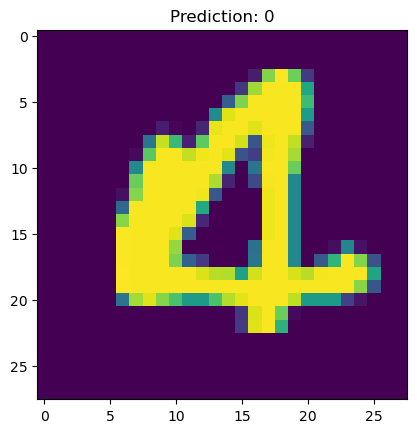

In [35]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [36]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [37]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model('/home/leey/devpub/leewyang/sparkext/examples/tensorflow/mnist_model')
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [38]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [39]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [40]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

23/05/09 09:28:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 975 ms, sys: 100 ms, total: 1.08 s
Wall time: 17.4 s


In [41]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 879 ms, sys: 126 ms, total: 1 s
Wall time: 6.67 s


In [42]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [43]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.9058766, -9.187449, -2.8795025, 1.3767852,..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.1935434, 5.1273246, 20.573282, -4.539008, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-10.045938, 8.538071, -5.0286736, -6.895411, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[12.549796, -9.799527, 1.2454411, -6.1566095, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.179978, -9.856197, -5.1661825, -11.582559,..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-11.890425, 12.078898, -8.224401, -7.385075, ..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-15.729789, -12.213417, -10.97453, -10.533624..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-12.187412, -6.018302, -2.655642, 0.13241738,..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-16.922424, -18.066164, -7.6085434, -8.022738..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-17.074114, -14.787377, -15.653712, -3.712963..."


In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
sample = preds.iloc[0]
sample.preds

array([ -4.9058766 ,  -9.187449  ,  -2.8795025 ,   1.3767852 ,
       -15.402968  ,  -7.6810102 , -19.185686  ,  11.043237  ,
        -4.409804  ,   0.70357424], dtype=float32)

In [46]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

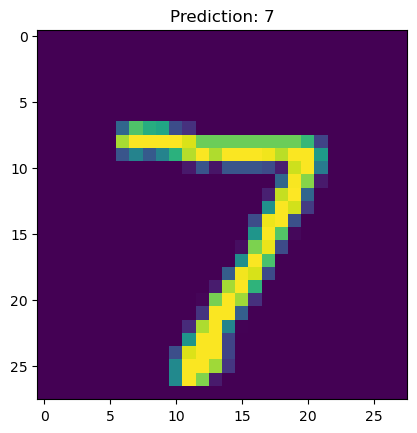

In [47]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### Using Triton Server
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [48]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

#### Start Triton Server on each executor

In [49]:
num_executors = 1

nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={"/home/leey/devpub/leewyang/sparkext/examples/models": {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.mapPartitions(start_triton).collect()

[True]

In [50]:
df = spark.read.parquet("mnist_test")

In [51]:
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

#### Using custom predict_batch_fn

In [52]:
def predict_batch_fn():
    import numpy as np
    import tritonclient.grpc as grpcclient
    client = grpcclient.InferenceServerClient("localhost:8001")
    def predict(inputs):
        request = [grpcclient.InferInput("dense_input", inputs.shape, "FP32")]
        request[0].set_data_from_numpy(inputs.astype(np.float32))
        response = client.infer("mnist_model", inputs=request)
        return response.as_numpy("dense_1")
    return predict

In [53]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=8192)

In [54]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 677 ms, sys: 80.5 ms, total: 757 ms
Wall time: 3.09 s


In [55]:
%%time
preds = df.withColumn("preds", mnist("data")).collect()

CPU times: user 552 ms, sys: 81.2 ms, total: 633 ms
Wall time: 1.65 s


In [56]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

CPU times: user 478 ms, sys: 124 ms, total: 602 ms
Wall time: 1.75 s


#### Check predictions

In [57]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.96356505, -7.777553, -2.576155, -5.882809, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.908359, -4.6471114, -4.9786873, -4.459195,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.274345, -12.872875, -2.614789, -7.81396, -5..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21.106869, -16.07338, -4.2054753, -13.336175,..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.681426, -14.107719, 10.882052, -0.2733218..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.56365, -14.510375, -5.442703, -14.467813, ..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.30349, -18.210304, -3.3546867, -4.0383105,..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.2747426, -10.959972, -10.929401, 1.1598731..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-17.085728, -7.17617, -6.550626, 17.210117, -..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.3158245, -17.406818, -6.4114347, -13.26391..."


In [58]:
import matplotlib.pyplot as plt
import numpy as np

In [59]:
sample = preds.iloc[0]
sample.preds

array([ 0.96356505, -7.777553  , -2.576155  , -5.882809  ,  0.55168307,
       -2.1888988 , -2.0618353 , -4.5619006 , -4.8376513 ,  3.2695212 ],
      dtype=float32)

In [60]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

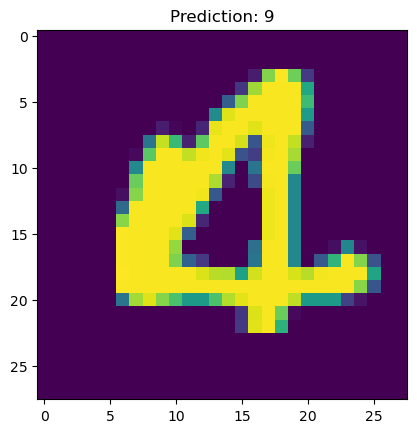

In [61]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Using generic Triton function

In [62]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient

    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)

    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))

        response = client.infer(model_name, inputs=request)

        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)

    return predict

In [63]:
from functools import partial

predict = predict_batch_udf(partial(triton_fn, "localhost:8001", "mnist_model"),
                            return_type=ArrayType(FloatType()),
                            input_tensor_shapes=[[784]],
                            batch_size=8192)

In [64]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 636 ms, sys: 93.2 ms, total: 729 ms
Wall time: 2.25 s


In [65]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 513 ms, sys: 85.9 ms, total: 599 ms
Wall time: 1.86 s


In [66]:
%%time
preds = df.withColumn("preds", predict(col("data"))).collect()

CPU times: user 825 ms, sys: 86.9 ms, total: 911 ms
Wall time: 2.01 s


#### Stop Triton Server on each executor

In [67]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.mapPartitions(stop_triton).collect()

[True]

In [68]:
spark.stop()